In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import imageio
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
from tqdm.notebook import tqdm
from IPython.display import HTML

In [4]:
warnings.filterwarnings("ignore")

In [5]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

In [6]:
np.random.seed(0)

# **Generate Data**

In [7]:
data, labels = make_blobs(n_samples = 1000, centers = 4, n_features = 2, random_state = 0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


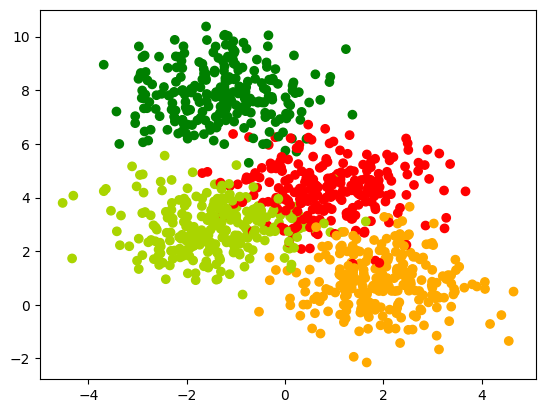

In [8]:
plt.scatter(data[:,0], data[:,1], c = labels, cmap = cmap)
plt.show()

In [9]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

# **MultiClass Classification**

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels_orig, stratify = labels_orig, random_state = 0)
print(X_train.shape, X_test.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [11]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test, 1)).toarray()
print(Y_OH_train.shape, Y_OH_test.shape)

(750, 4) (250, 4)


# **FF Network**

In [19]:
class FFNetwork():
    def __init__(self, init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1):
        self.params = {}
        self.param_h = []
        self.num_layers = 2
        self.layer_size = [2, 2, 4]
        self.init_method = init_method
        self.activation_function = activation_function
        self.leaky_slope = leaky_slope
        np.random.seed(0)
        if(init_method == "random"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i])
                self.params["B" + str(i)] = np.random.randn(1, self.layer_size[i])
        elif(init_method == "he"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i]) * (np.sqrt(2 / self.layer_size[i-1]))
                self.params["B" + str(i)] = np.random.randn(1, self.layer_size[i]) * (np.sqrt(2 / self.layer_size[i-1]))
        elif(init_method == "xavier"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i]) * (np.sqrt(1 / self.layer_size[i-1]))
                self.params["B" + str(i)] = np.random.randn(1, self.layer_size[i]) * (np.sqrt(1 / self.layer_size[i-1]))
        elif(init_method == "zeros"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.zeros((self.layer_size[i-1], self.layer_size[i]))
                self.params["B" + str(i)] = np.zeros((1, self.layer_size[i]))
        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}
        for i in range(1, self.num_layers + 1):
            self.update_params["v_w" + str(i)] = 0
            self.update_params["v_b" + str(i)] = 0
            self.update_params["m_w" + str(i)] = 0
            self.update_params["m_b" + str(i)] = 0
            self.prev_update_params["v_w" + str(i)] = 0
            self.prev_update_params["v_b" + str(i)] = 0
    def forward_activation(self , X):
        if (self.activation_function == "sigmoid"):
            return 1 / (1 + np.exp(-X))
        elif (self.activation_function == "tanh"):
            return np.tanh(X)
        elif (self.activation_function == "relu"):
            return np.maximum(0, X)
        elif (self.activation_function == "leaky_relu"):
            return np.maximum(self.leaky_slope * X, X)
    def grad_activation(self, X):
        if(self.activation_function == "sigmoid"):
            return X * (1 - X)
        elif(self.activation_function == "tanh"):
            return 1 - np.square(X)
        elif(self.activation_function == "relu"):
            return 1 * (X > 0)
        elif(self.activation_function == "leaky_relu"):
            d = np.zeros_like(X)
            d[X <= 0] = self.leaky_slope
            d[X > 0] = 1
            return d
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1,1)
    def forward_pass(self, X, params = None):
        if params == None:
            params = self.params
        self.A1 = np.matmul(X, params["W1"]) + params["B1"]
        self.H1 = self.forward_activation(self.A1)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]
        self.H2 = self.softmax(self.A2)
        return self.H2
    def grad(self, X, Y, params = None):
        if params == None:
            params = self.params
        self.forward_pass(X, params)
        self.gradients["dA2"] = self.H2 - Y                 #(N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1,-1)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1,-1)
    def predict(self, X):
        return np.array(self.forward_pass(X)).squeeze()
    def fit(self, X, Y, epochs = 1, algo = "GD", display_loss = False, eta = 1, eps = 1e-8, min_batch_size = 100,
            beta = 0.9, beta1 = 0.9, beta2 = 0.9, gamma = 0.9):
        if display_loss == True:
            loss = {}
            Y_pred = self.predict(X)
            loss[0] = log_loss(np.argmax(Y, axis = 1), Y_pred)
        for epoch in tqdm(range(epochs), total = epochs, unit = "epoch"):
            m = X.shape[0]
            if algo == "GD":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
            elif algo == "MiniBatch":
                for k in range(0, m, mini_batch_size):
                    self.grad(X[k: k + mini_batch_size], Y[k, k + mini_batch_size])
                    for i in range(1, self.num_layers + 1):
                        self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
                        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            elif algo == "Momentum":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]
            elif algo == "NAG":
                temp_params = {}
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]
                    temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
                self.grad(X, Y, temp_params)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
                    self.params["W"+str(i)] -= eta * self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= eta * self.update_params["v_b"+str(i)]
                self.prev_update_params = self.update_params
            elif algo == "AdaGrad":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)]/m)
            elif algo == "RMSProp":
                self.grad(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] + (1-beta)*((self.gradients["dW"+str(i)]/m)**2)
                    self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] + (1-beta)*((self.gradients["dB"+str(i)]/m)**2)
                    self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)]/m)
            elif algo == "Adam":
                self.grad(X, Y)
                num_updates = 0
                for i in range(1 + self.num_layers + 1):
                    num_updates += 1
                    self.update_params["m_w"+str(i)] = beta1*self.update_params["m_w"+str(i)] + (1-beta1)*(self.gradients["dW"+str(i)]/m)
                    self.update_params["m_b"+str(i)] = beta1*self.update_params["m_b"+str(i)] + (1-beta1)*(self.gradients["dB"+str(i)]/m)
                    self.update_params["v_w"+str(i)] = beta2*self.update_params["v_w"+str(i)] + (1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
                    self.update_params["v_b"+str(i)] = beta2*self.update_params["v_b"+str(i)] + (1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
                    m_w_h = self.update_params["m_w"+str(i)] / (1 - np.power(beta1,num_updates))
                    m_b_h = self.update_params["m_b"+str(i)] / (1 - np.power(beta1,num_updates))
                    v_w_h = self.update_params["v_w"+str(i)] / (1 - np.power(beta2,num_updates))
                    v_b_h = self.update_params["v_b"+str(i)] / (1 - np.power(beta2,num_updates))
                    self.params["W"+str(i)] -= (eta/(np.sqrt(v_w_h)+eps))*m_w_h
                    self.params["B"+str(i)] -= (eta/(np.sqrt(v_b_h)+eps))*m_b_h
            if display_loss:
                    Y_pred = self.predict(X)
                    loss[epoch+1] = log_loss(np.argmax(Y, axis = 1), Y_pred)
                    self.param_h.append(np.concatenate((self.params["W1"].ravel(),self.params["W2"].ravel(),self.params["B1"].ravel(),self.params["B2"].ravel())))
        if display_loss:
            plt.plot(loss.values(), '-o', markersize = 5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()

In [13]:
def post_process(scatter_plot = False, gradient_plot = True, plot_scale = 0.1):
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_test = model.predict(X_test)
    Y_pred_test = np.argmax(Y_pred_test, 1)
    train_accuracy = accuracy_score(Y_pred_train, Y_train)
    test_accuracy = accuracy_score(Y_pred_test, Y_test)
    print("Training accuracy", round(train_accuracy, 4))
    print("Test accuracy", round(test_accuracy, 4))
    if scatter_plot:
        plt.scatter(X_train[:,0], X_train[:,1], c = Y_pred_train, cmap = cmap)
        plt.show()
    if gradient_plot:
        h = np.asarray(model.param_h)
        h_diff = (h[0:-1,:] - h[1:,:]) # point-wise difference (consecutive diff)
        for i in range(18):
            plt.subplot(6, 3, i+1)
            plt.plot(h_diff[:,i],'-')
            plt.ylim((-plot_scale, plot_scale))
            plt.yticks([])
            plt.xticks([])
        plt.show()

  0%|          | 0/10 [00:00<?, ?epoch/s]

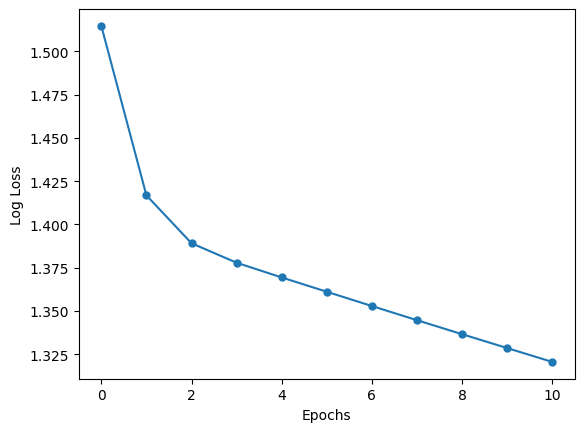

Training accuracy 0.4587
Test accuracy 0.468


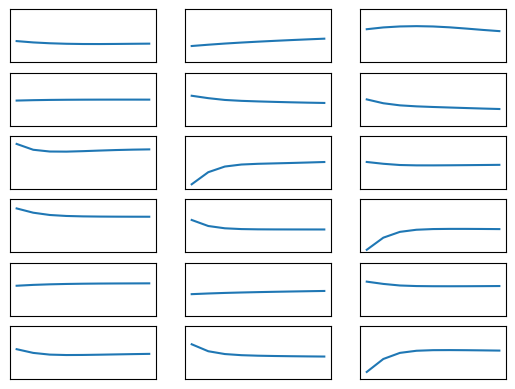

In [14]:
model = FFNetwork(init_method = 'xavier', activation_function='sigmoid')
model.fit(X_train, Y_OH_train, epochs = 10, eta = 1, algo ="GD", display_loss = True)
post_process()

zeros , sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

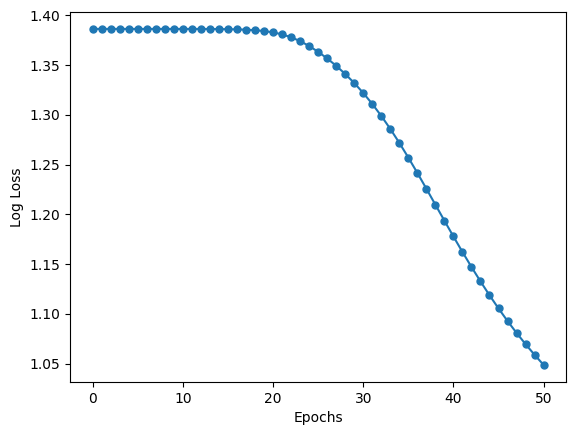

Training accuracy 0.528
Test accuracy 0.54


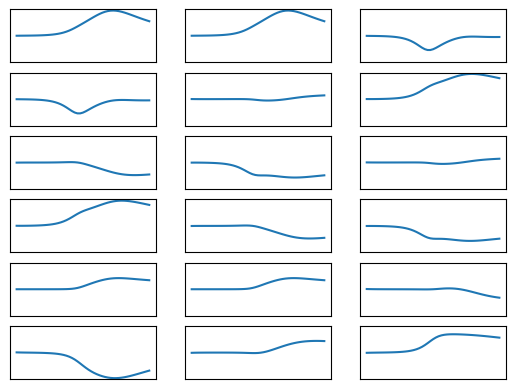


--

random , sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

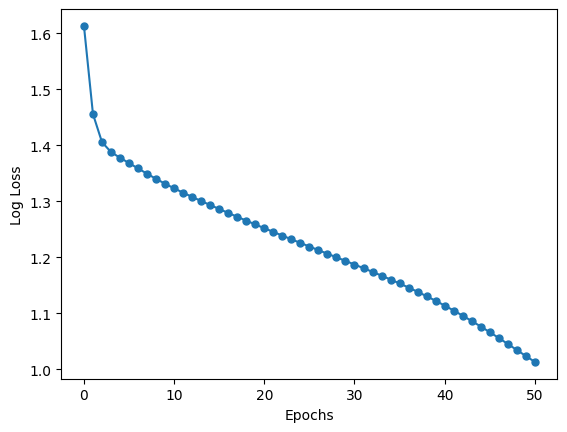

Training accuracy 0.5827
Test accuracy 0.568


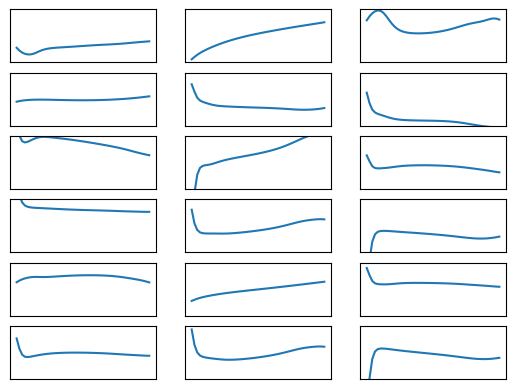


--

xavier , sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

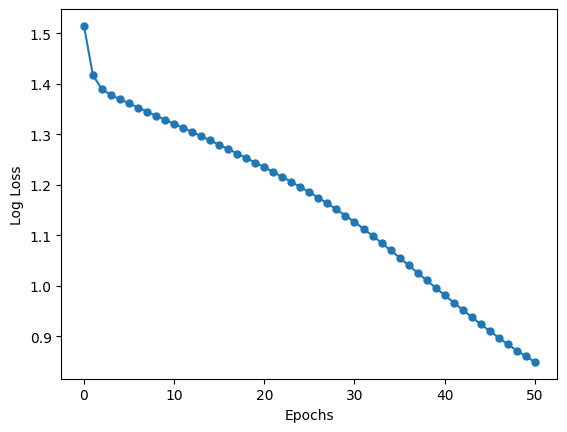

Training accuracy 0.676
Test accuracy 0.664


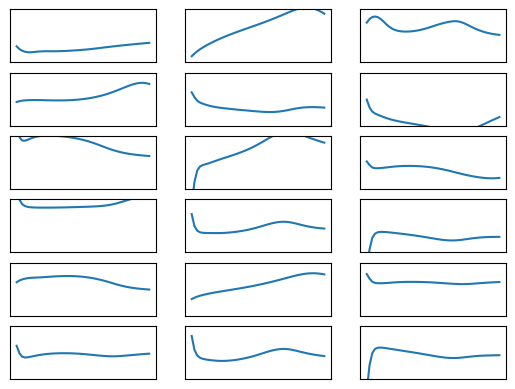


--

he , sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

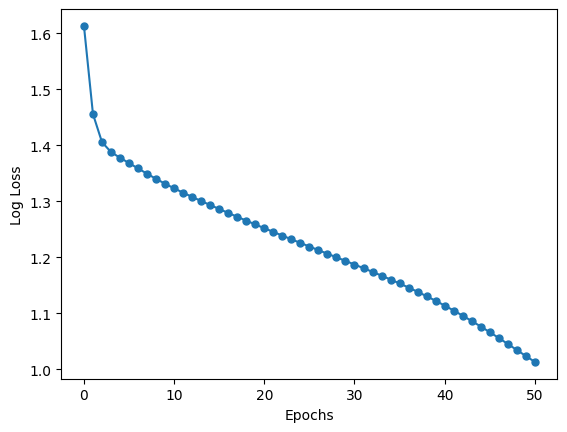

Training accuracy 0.5827
Test accuracy 0.568


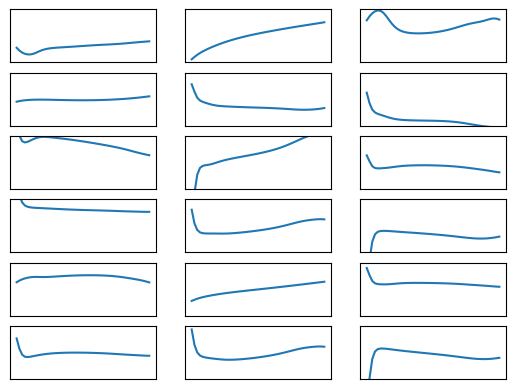


--



In [15]:
for init_method in ["zeros", "random", "xavier", "he"]:
    for activation_function in ['sigmoid']:
        print(init_method,",",activation_function)
        model = FFNetwork(init_method = init_method, activation_function = activation_function)
        model.fit(X_train, Y_OH_train, epochs = 50, eta = 1, algo ="GD", display_loss = True)
        post_process(plot_scale = 0.05)
        print("\n--\n")

zeros , tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

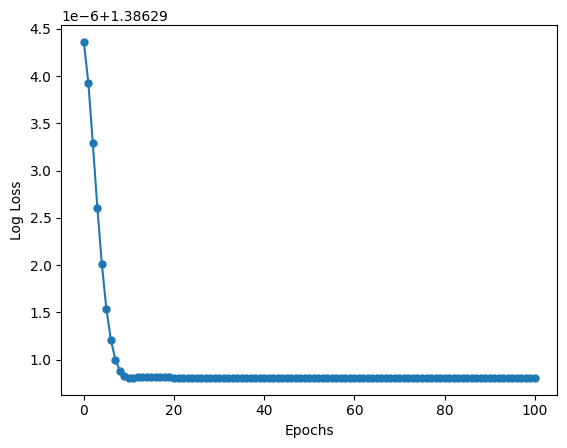

Training accuracy 0.2507
Test accuracy 0.248


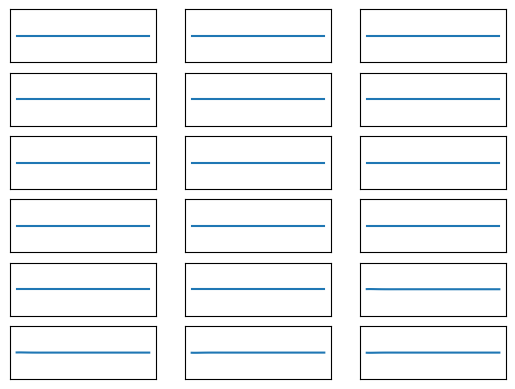


--

random , tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

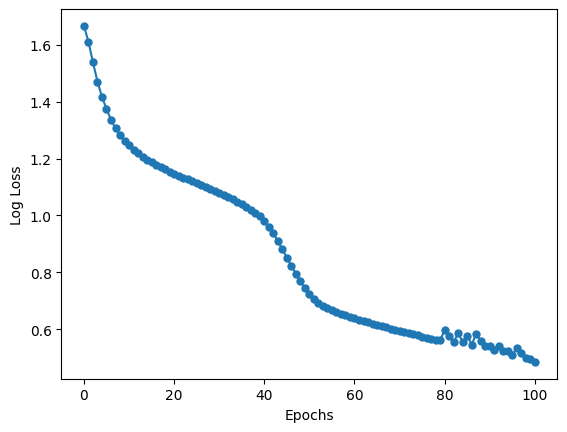

Training accuracy 0.8547
Test accuracy 0.86


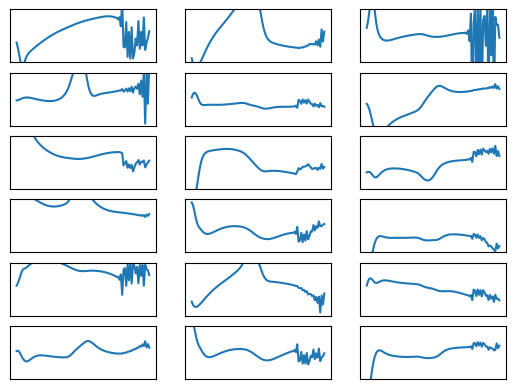


--

xavier , tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

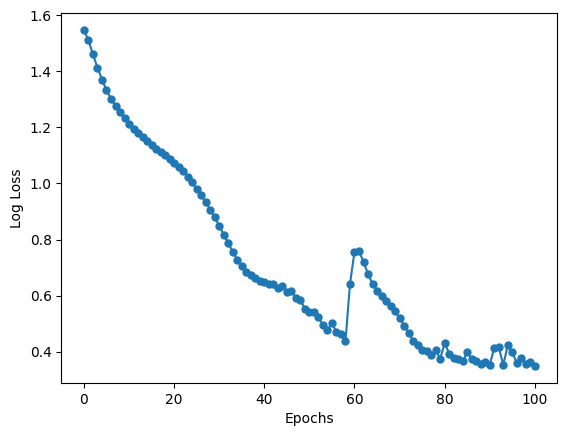

Training accuracy 0.8773
Test accuracy 0.884


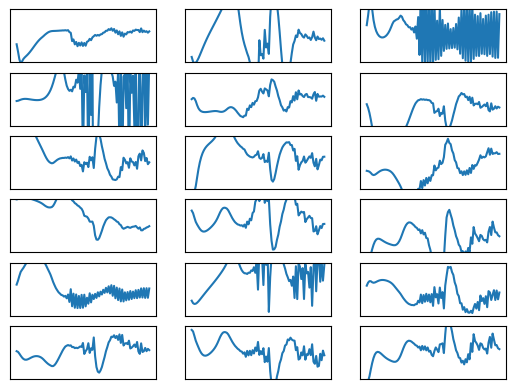


--

he , tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

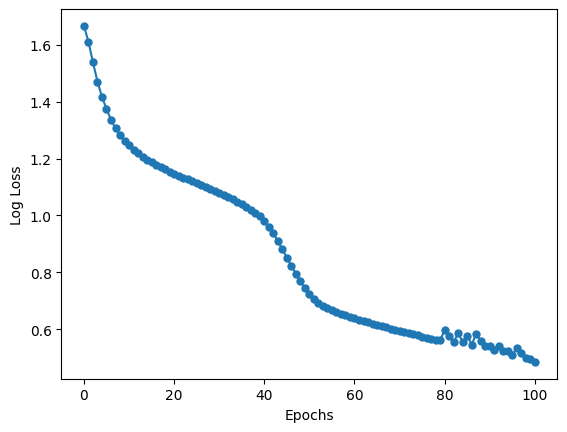

Training accuracy 0.8547
Test accuracy 0.86


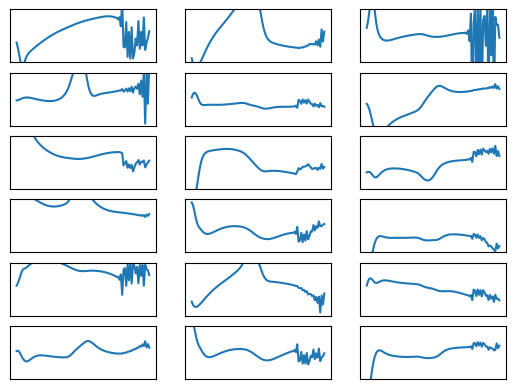


--



In [23]:
for init_method in ["zeros", "random", "xavier", "he"]:
    for activation_function in ['tanh']:
        print(init_method,",",activation_function)
        model = FFNetwork(init_method = init_method, activation_function = activation_function)
        model.fit(X_train, Y_OH_train, epochs = 100, eta = 0.5, algo ="NAG", display_loss = True)
        post_process(plot_scale = 0.05)
        print("\n--\n")

zeros , relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

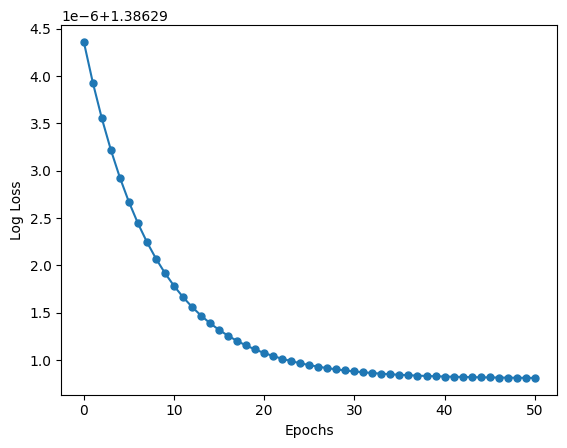

Training accuracy 0.2507
Test accuracy 0.248


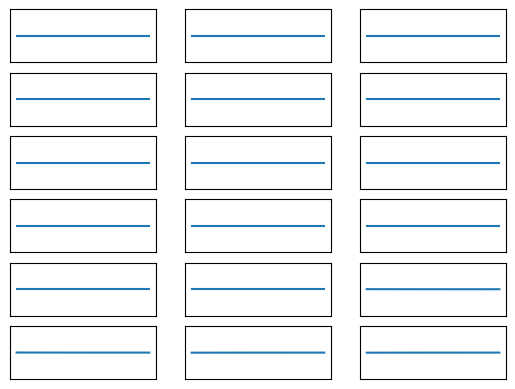


--

random , relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

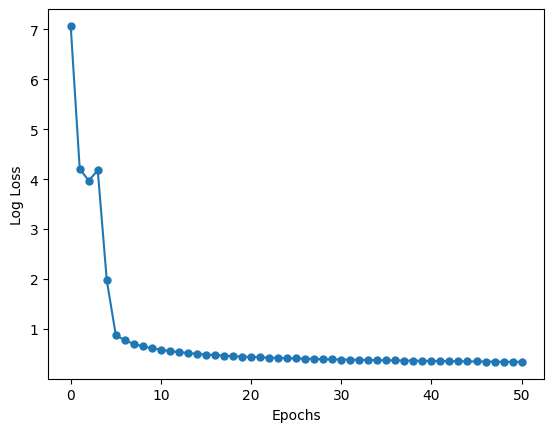

Training accuracy 0.9067
Test accuracy 0.92


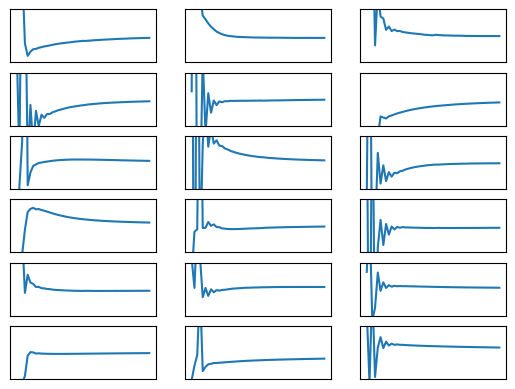


--

xavier , relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

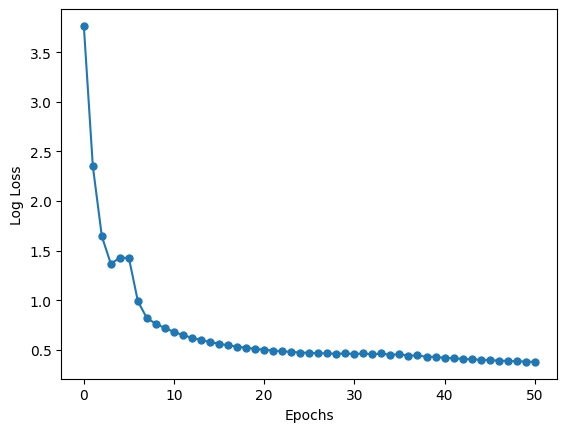

Training accuracy 0.8973
Test accuracy 0.92


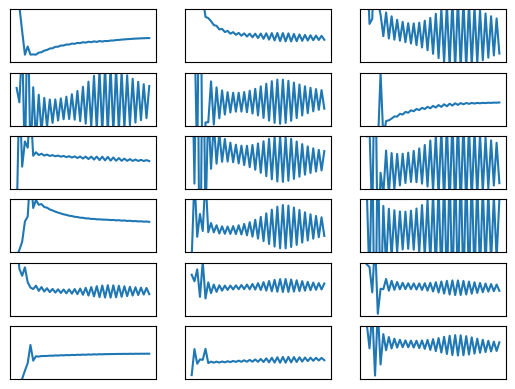


--

he , relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

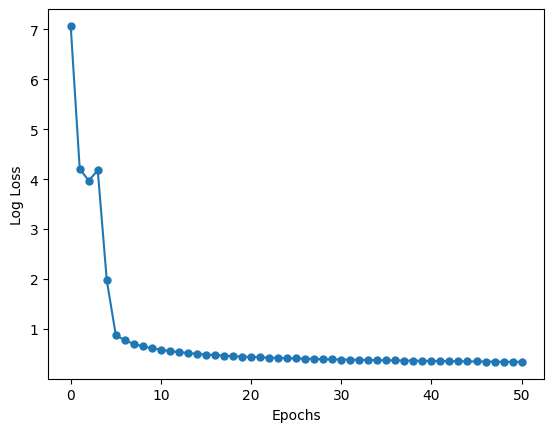

Training accuracy 0.9067
Test accuracy 0.92


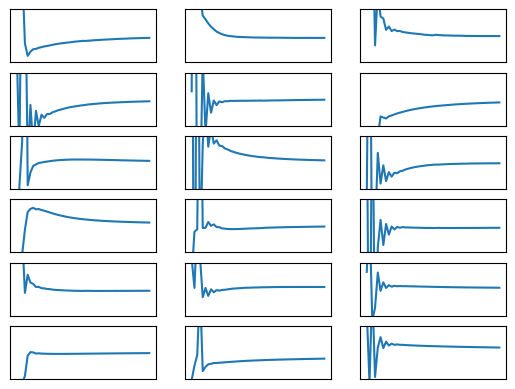


--



In [24]:
for init_method in ["zeros", "random", "xavier", "he"]:
    for activation_function in ['relu']:
        print(init_method,",",activation_function)
        model = FFNetwork(init_method = init_method, activation_function = activation_function)
        model.fit(X_train, Y_OH_train, epochs = 50, eta = 0.25, algo ="GD", display_loss = True)
        post_process(plot_scale = 0.05)
        print("\n--\n")

zeros , leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

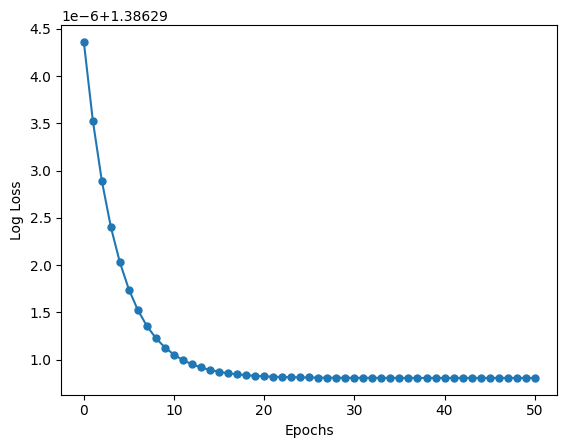

Training accuracy 0.2507
Test accuracy 0.248


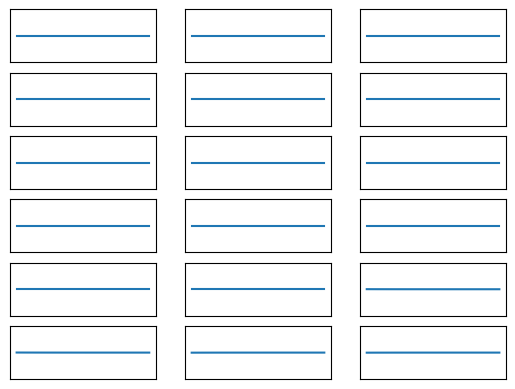


--

random , leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

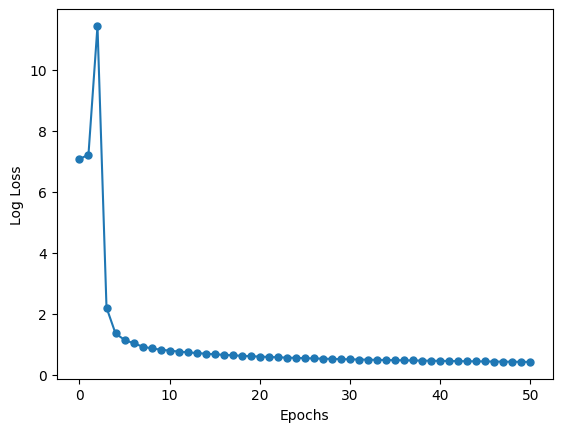

Training accuracy 0.8933
Test accuracy 0.9


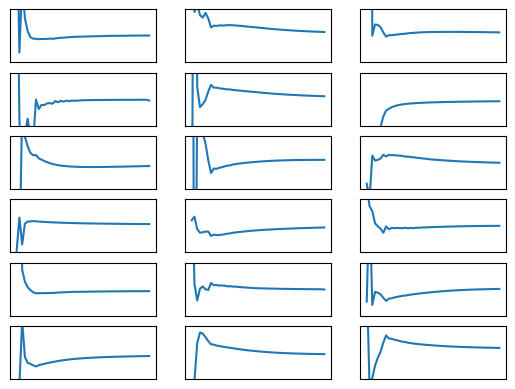


--

xavier , leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

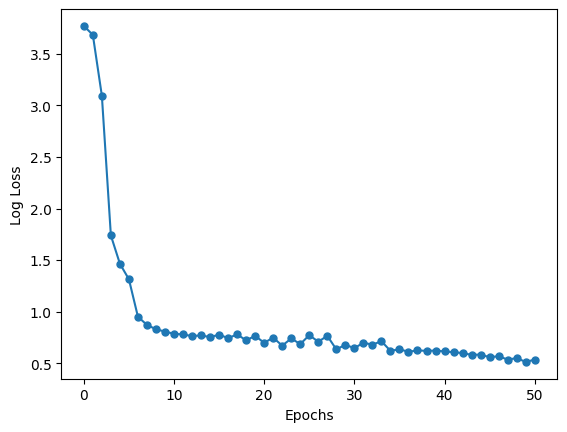

Training accuracy 0.7707
Test accuracy 0.78


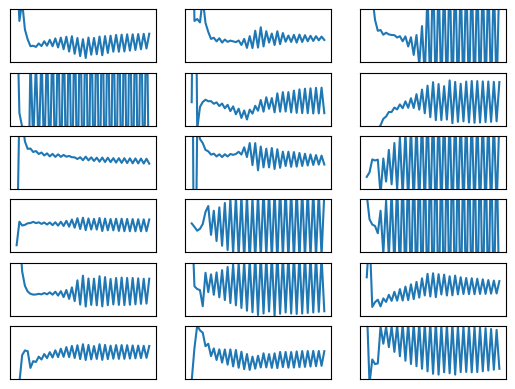


--

he , leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

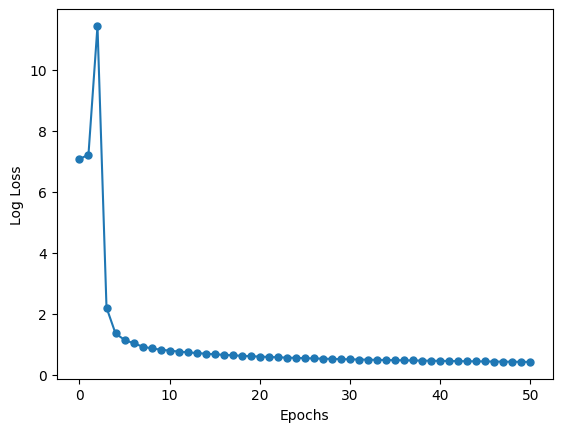

Training accuracy 0.8933
Test accuracy 0.9


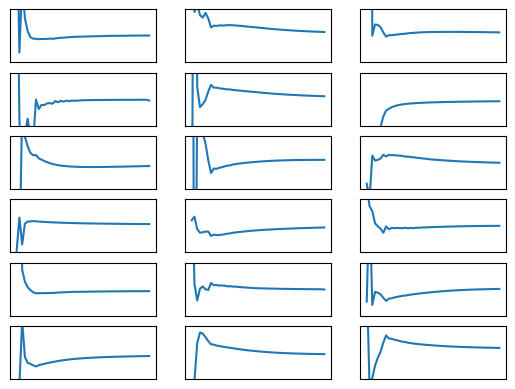


--



In [25]:
for init_method in ["zeros", "random", "xavier", "he"]:
    for activation_function in ['leaky_relu']:
        print(init_method,",",activation_function)
        model = FFNetwork(init_method = init_method, activation_function = activation_function)
        model.fit(X_train, Y_OH_train, epochs = 50, eta = 0.5, algo ="GD", display_loss = True)
        post_process(plot_scale = 0.1)
        print("\n--\n")